# Purpose

This notebook compares return and volatility forecasting models, and summarises their relative performance for business interpretation.

All forecasts are evaluated at a one-step-ahead horizon using out-of-sample data from 2022–2024.

# Imports and configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Load model outputs

## Reutrns

In [2]:
returns_df = pd.read_csv(
    "../data/processed/daily_returns.csv",
    index_col=0,
    parse_dates=True
)
returns_df.index = pd.to_datetime(returns_df.index)
returns_df = returns_df.sort_index()

returns = returns_df["adj_log_return"]

In [3]:
# Baseline mean
split_date = "2022-01-01"
train = returns.loc[returns.index < split_date]
test  = returns.loc[returns.index >= split_date]

baseline_return_forecast = pd.Series(
    train.mean(),
    index=test.index
)

In [4]:
# ARIMA forecasts
arima_forecasts = pd.read_csv(
    "../outputs/forecasts/arima_return_forecast.csv",
    index_col=0,
    parse_dates=True
).squeeze()

## Volatility

In [5]:
# Realised volatility
vol_df = pd.read_csv(
    "../data/processed/realised_volatility_21d.csv",
    index_col=0,
    parse_dates=True
)

vol_df.index = pd.to_datetime(vol_df.index)
vol_df = vol_df.sort_index()

realised_vol = vol_df["realised_vol_21d"]

In [6]:
# Naive Benchmark
naive_vol = realised_vol.shift(1).bfill()

In [7]:
# ETS forecasts
ets_forecasts = pd.read_csv(
    "../outputs/forecasts/ets_volatility_forecast.csv",
    index_col=0,
    parse_dates=True
).squeeze()

In [8]:
# GARCH forecasts
garch_forecasts = pd.read_csv(
    "../outputs/forecasts/garch_volatility_forecast.csv",
    index_col=0,
    parse_dates=True
).squeeze()

## Global Alignment

In [9]:
# Align indices
common_index = realised_vol.index.intersection(ets_forecasts.index).intersection(garch_forecasts.index)

test_returns = test.loc[common_index]
baseline_return_forecast = baseline_return_forecast.loc[common_index]
arima_forecasts = arima_forecasts.loc[common_index]

naive_vol = naive_vol.loc[common_index]
realised_vol = realised_vol.loc[common_index]
ets_forecasts = ets_forecasts.loc[common_index]
garch_forecasts = garch_forecasts.loc[common_index]

## Transformation

ETS forecasts the 21-day rolling volatility. GARCH forecasts 1-day volatility. To compare fairly, we smooth the GARCH forecasts using the same 21-day window logic.

In [10]:
# Horizon Alignment
garch_21d_proxy = np.sqrt((garch_forecasts**2).rolling(window=21).mean())
garch_21d_proxy = garch_21d_proxy.bfill()

We use a rolling mean of variances to approximate the 21-day volatility construction.

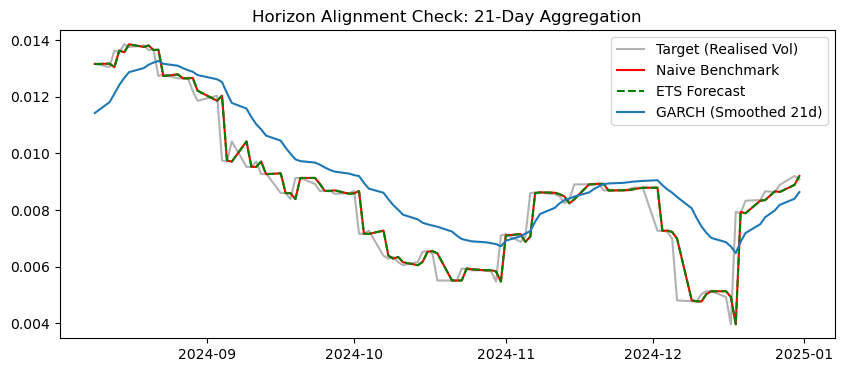

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(realised_vol[-100:], label="Target (Realised Vol)", color='black', alpha=0.3)
plt.plot(naive_vol[-100:], label="Naive Benchmark", color='red')
plt.plot(ets_forecasts[-100:], label="ETS Forecast", color='green', linestyle='--')
plt.plot(garch_21d_proxy[-100:], label="GARCH (Smoothed 21d)")
plt.title("Horizon Alignment Check: 21-Day Aggregation")
plt.legend()
plt.show()

Naive Benchmark (red) and ETS Forecast (green dashed) overlap almost perfectly

Aggregating the daily GARCH forecasts into a 21-day rolling average creates a series comparable to the ETS and Naive benchmarks.

GARCH tracks the trend and level of the target, Realised Volatility, though with a noticeable lag and smoother profile due to Persistence ($\beta$). This also proves it is actually providing a different signal, rather than just blindly following the backward-looking moving average.

# Return model comparison

In [12]:
baseline_mae = mean_absolute_error(test_returns, baseline_return_forecast)
baseline_rmse = root_mean_squared_error(test_returns, baseline_return_forecast)
arima_mae = mean_absolute_error(test_returns, arima_forecasts)
arima_rmse = root_mean_squared_error(test_returns, arima_forecasts)

In [13]:
return_results = pd.DataFrame({
    "Model": ["Baseline Mean", "ARIMA", "Improvement"],
    "MAE": [
        f'{baseline_mae:.6f}',
        f'{arima_mae:.6f}',
        f'{(1 - arima_mae/baseline_mae)*100:.2f}%'
    ],
    "RMSE": [
        f'{baseline_rmse:.6f}',
        f'{arima_rmse:.6f}',
        f'{(1 - arima_rmse/baseline_rmse)*100:.2f}%'
    ]
})

return_results.style.hide(axis='index')

Model,MAE,RMSE
Baseline Mean,0.008104,0.011026
ARIMA,0.008217,0.011114
Improvement,-1.40%,-0.80%


ARIMA provide negligible improvement over baseline.

# Volatility model comparison

In [14]:
naive_mae = mean_absolute_error(realised_vol, naive_vol)
naive_rmse = root_mean_squared_error(realised_vol, naive_vol)
ets_mae = mean_absolute_error(realised_vol, ets_forecasts)
ets_rmse = root_mean_squared_error(realised_vol, ets_forecasts)
garch_daily_mae = mean_absolute_error(realised_vol, garch_forecasts)
garch_daily_rmse = root_mean_squared_error(realised_vol, garch_forecasts)
garch_21d_mae = mean_absolute_error(realised_vol, garch_21d_proxy)
garch_21d_rmse = root_mean_squared_error(realised_vol, garch_21d_proxy)

In [21]:
vol_results = pd.DataFrame({
    "Model": ["Naive", "ETS", "GARCH (Daily)", "GARCH (21d Smoothed)", "Improvement (GARCH 21d vs Naive)"],
    "MAE": [
        f'{naive_mae:.6f}',
        f'{ets_mae:.6f}',
        f'{garch_daily_mae:.6f}',
        f'{garch_21d_mae:.6f}',
        f'{(1 - garch_21d_mae/naive_mae)*100:.2f}%'
    ],
    "RMSE": [
        f'{naive_rmse:.6f}',
        f'{ets_rmse:.6f}',
        f'{garch_daily_rmse:.6f}',
        f'{garch_21d_rmse:.6f}',
        f'{(1 - garch_21d_rmse/naive_rmse)*100:.2f}%'
    ],
    "MAE_Ann (%)": [
        f'{naive_mae * np.sqrt(252) * 100:.2f}%',
        f'{ets_mae * np.sqrt(252) * 100:.2f}%',
        f'{garch_daily_mae * np.sqrt(252) * 100:.2f}%',
        f'{garch_21d_mae * np.sqrt(252) * 100:.2f}%',
        '-'
    ],
    "RMSE_Ann (%)": [
        f'{naive_rmse * np.sqrt(252) * 100:.2f}%',
        f'{ets_rmse * np.sqrt(252) * 100:.2f}%',
        f'{garch_daily_rmse * np.sqrt(252) * 100:.2f}%',
        f'{garch_21d_rmse * np.sqrt(252) * 100:.2f}%',
        '-'
    ]
})

vol_results.style.hide(axis='index')

Model,MAE,RMSE,MAE_Ann (%),RMSE_Ann (%)
Naive,0.000351,0.000592,0.56%,0.94%
ETS,0.000351,0.000592,0.56%,0.94%
GARCH (Daily),0.001444,0.001963,2.29%,3.12%
GARCH (21d Smoothed),0.000974,0.001222,1.55%,1.94%
Improvement (GARCH 21d vs Naive),-177.33%,-106.44%,-,-


Simple benchmarks (i.e., Naive & ETS) outperform on error metrics by tracking the high autocorrelation of the 21-day realised volatility series.

Smoothing GARCH forecasts to a 21-day horizon still cannot compete with Naive or ETS, but it reduces MAE/RMSE by 30-40% compared to daily spot risk, confirming better structural alignment.

# Visual comparison

## Returns

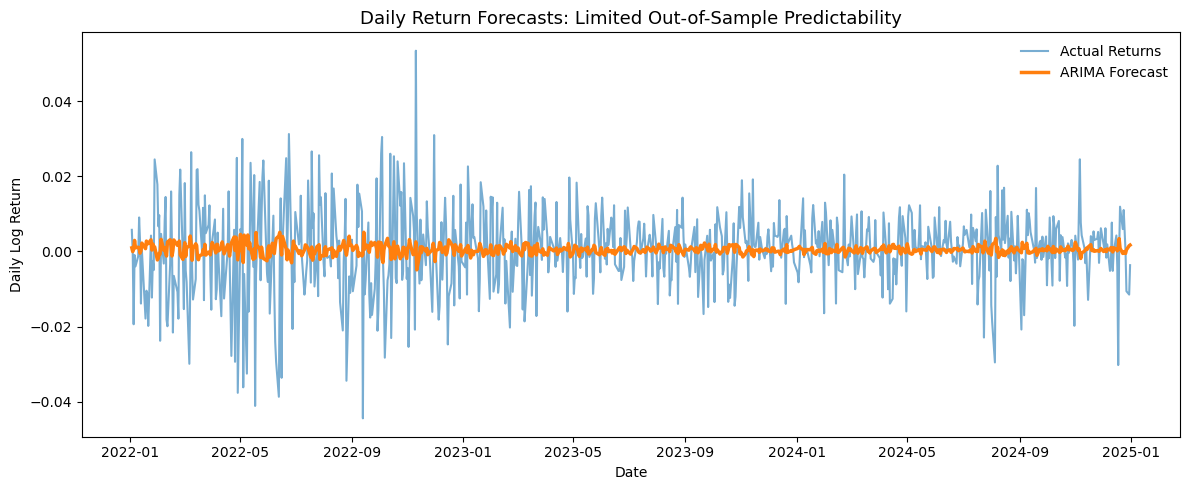

In [16]:
plt.figure(figsize=(12, 5))

plt.plot(
    test_returns.index,
    test_returns,
    label="Actual Returns",
    linewidth=1.5,
    alpha=0.6
)

plt.plot(
    arima_forecasts.index,
    arima_forecasts,
    label="ARIMA Forecast",
    linewidth=2.5
)

plt.title(
    "Daily Return Forecasts: Limited Out-of-Sample Predictability",
    fontsize=13
)

plt.xlabel("Date")
plt.ylabel("Daily Log Return")

plt.legend(frameon=False)
plt.tight_layout()

plt.savefig(
    "../outputs/figures/return_forecast_comparison.png",
    dpi=150
)

plt.show()

Actual returns are wild, noisy, spiky. There are large positive and negative moves. Classic daily equity returns.

ARIMA forecasts smooth around zero with very low variance.

## Volatility

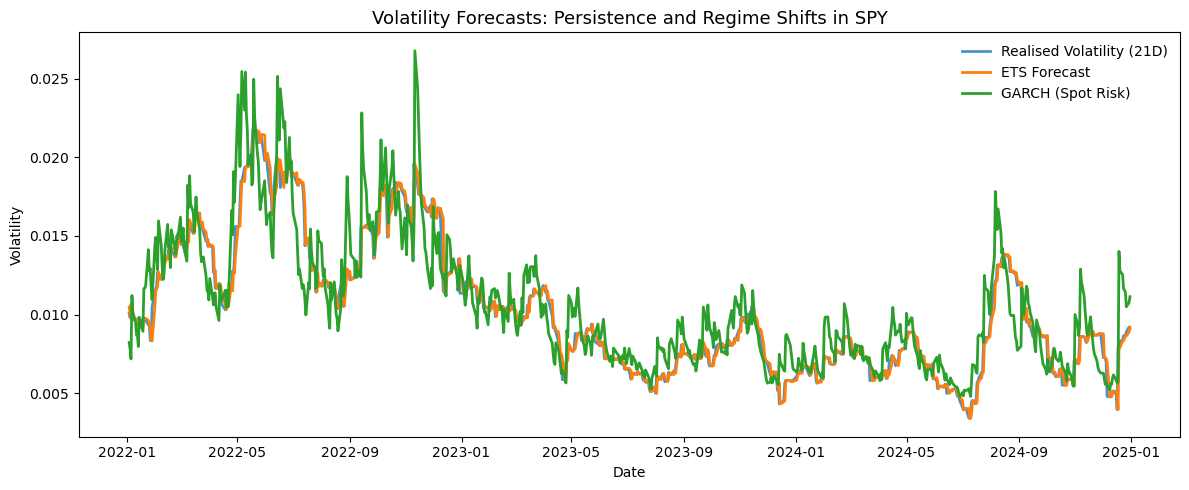

In [17]:
plt.figure(figsize=(12, 5))

plt.plot(
    realised_vol.index,
    realised_vol,
    label="Realised Volatility (21D)",
    linewidth=2,
    alpha=0.8
)

plt.plot(
    ets_forecasts.index,
    ets_forecasts,
    label="ETS Forecast",
    linewidth=2
)

plt.plot(
    garch_forecasts.index,
    garch_forecasts,
    label="GARCH (Spot Risk)",
    linewidth=2
)

plt.title(
    "Volatility Forecasts: Persistence and Regime Shifts in SPY",
    fontsize=13
)

plt.xlabel("Date")
plt.ylabel("Volatility")

plt.legend(frameon=False)
plt.tight_layout()

plt.savefig(
    "../outputs/figures/volatility_forecast_comparison.png",
    dpi=150
)

plt.show()

Realised volatility has clear regimes. High in 2022, declining into 2023, spikes again in late 2024.

ETS forecasts are smooth, lagged, stable. They track level well while slow to react.

GARCH forecasts are more jagged. They react sharply to shocks while overshoot during stress.

# Save forecasts and summary tables

In [23]:
garch_21d_proxy.to_csv("../outputs/forecasts/garch_21d_smoothed_forecast.csv")

In [22]:
return_results.to_csv("../outputs/tables/return_model_comparison.csv", index=False)
vol_results.to_csv("../outputs/tables/volatility_model_comparison.csv", index=False)